In [1]:
import os
import cv2
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras import optimizers, applications
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

import keras.backend as K

%matplotlib inline
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')

In [2]:
test = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/testLabels15.csv')
test.shape

(53576, 3)

In [3]:
#select only Private Label
test = test[test['Usage'] == 'Private']

In [4]:
test.shape

(42670, 3)

In [5]:
test['image'] = test['image'].apply(lambda x: x + '.jpg')

### Found imagens in dataset 2015

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = '../input/resized-2015-2019-blindness-detection-images/resized test 15',
    x_col = 'image',
    y_col= 'level',
    target_size = (512,512),
    batch_size = 1,
    shuffle = False,
    class_mode = None
)

Found 42670 validated image filenames.


In [7]:
step_size = test_generator.n // test_generator.batch_size

In [8]:
def test_models(model_name,models):
    
    preds_tta0 = []
    preds_tta1 = []
    preds_tta2 = []
    preds_tta3 = []
    preds_tta4 = []
    preds = []

        #model fold 0
    test_generator.reset()
    preds0 = xception0.predict_generator(generator=test_generator, steps=step_size)
    preds_tta0.append(preds0)

    #model fold 1
    test_generator.reset()
    preds1 = models[1].predict_generator(generator=test_generator, steps=step_size)
    preds_tta1.append(preds1)
   
        #model fold 2
    test_generator.reset()
    preds2 = models[2].predict_generator(generator=test_generator, steps=step_size)
    preds_tta2.append(preds2)

        #model fold 3
    test_generator.reset()
    preds3 = models[3].predict_generator(generator=test_generator, steps=step_size)
    preds_tta3.append(preds3)

        #model fold 4
    test_generator.reset()
    preds4 = models[4].predict_generator(generator=test_generator, steps=step_size)
    preds_tta4.append(preds4)
    
    print('------------------{}---------------------\n'.format(model_name))

    preds0 = sum(preds_tta0)
    preds1 = sum(preds_tta1)
    preds2 = sum(preds_tta2)
    preds3 = sum(preds_tta3)
    preds4 = sum(preds_tta4)

    filenames = test_generator.filenames
    
    results=pd.DataFrame({"id_code":filenames,
                      'diagnosis':test.level,
                        'pred0':preds0.argmax(axis=1),
                        'pred1':preds1.argmax(axis=1),
                        'pred2':preds2.argmax(axis=1),
                        'pred3':preds3.argmax(axis=1),
                        'pred4':preds4.argmax(axis=1)
                        })    

    print('FOLD 0: ',np.mean(np.equal(results.pred0, test['level'])))
    print('FOLD 1: ',np.mean(np.equal(results.pred1, test['level'])))
    print('FOLD 2: ',np.mean(np.equal(results.pred2, test['level'])))
    print('FOLD 3: ',np.mean(np.equal(results.pred3, test['level'])))
    print('FOLD 4: ',np.mean(np.equal(results.pred4, test['level'])))
    
    print('ENSEMBLE: ',np.mean(np.equal(results[['pred0','pred1']].mode(axis=1)[0], results['diagnosis'])))
    print('\n\n')
    labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
    cnf_matrix = confusion_matrix(test['level'].astype('int'), results[['pred0','pred1','pred2','pred3','pred4']].mode(axis=1)[0].astype('int'))
    cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
    plt.figure(figsize=(16, 7))
    plt.title(f'Confusion Matrix - {model_name}')
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
    plt.show()
    return results

In [9]:
#xception
xception0 = load_model('../input/models/old+new data/Xception/Xception-f0.h5')
xception1 = load_model('../input/models/old+new data/Xception/xcp-f1 2.h5')
xception2 = load_model('../input/models/old+new data/Xception/xcp-f1.h5')
xception3 = load_model('../input/models/old+new data/Xception/xcp-f3.h5')
xception4 = load_model('../input/models/old+new data/Xception/xcp-f4.h5')

#inceptionresnetv2
inception0 = load_model('../input/models/old+new data/InceptionResNet/InceptionResNetV2-fold0.h5')
inception1 = load_model('../input/models/old+new data/InceptionResNet/InceptionResNetV2-fold1.h5')
inception2 = load_model('../input/models/old+new data/InceptionResNet/InceptionResNetV2-fold2.h5')
inception3 = load_model('../input/models/old+new data/InceptionResNet/InceptionResNetV2-fold3.h5')
inception4 = load_model('../input/models/old+new data/InceptionResNet/InceptionResNetV2-fold4.h5')

#nasnetmobile
nasnet0 = load_model('../input/models/old+new data/NasNetMobile/NASNETMOBILE-f0.h5')
nasnet1 = load_model('../input/models/old+new data/NasNetMobile/NASNETMOBILE-f1.h5')
nasnet2 = load_model('../input/models/old+new data/NasNetMobile/NASNETMOBILE-f2.h5')
nasnet3 = load_model('../input/models/old+new data/NasNetMobile/NASNETMOBILE-f3.h5')
nasnet4 = load_model('../input/models/old+new data/NasNetMobile/NASNETMOBILE-f4.h5')

#efficientnetb0
eff0 = load_model('../input/models/old+new data/EfficientNetB0/effb0-f0.h5')
eff1 = load_model('../input/models/old+new data/EfficientNetB0/effb0-f1.h5')
eff2 = load_model('../input/models/old+new data/EfficientNetB0/effb0-f2.h5')
eff3 = load_model('../input/models/old+new data/EfficientNetB0/effb0-f3.h5')
eff4 = load_model('../input/models/old+new data/EfficientNetB0/effb0-f4.h5')

2022-11-10 13:42:33.323060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:42:33.435080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:42:33.435906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:42:33.437036: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2022-11-10 13:45:17.345515: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-10 13:45:18.855820: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


------------------Xception---------------------

FOLD 0:  0.7568314975392547
FOLD 1:  0.6027185376142489
FOLD 2:  0.6980314037965784
FOLD 3:  0.7321771736583079
FOLD 4:  0.6955706585423014
ENSEMBLE:  0.750269510194516





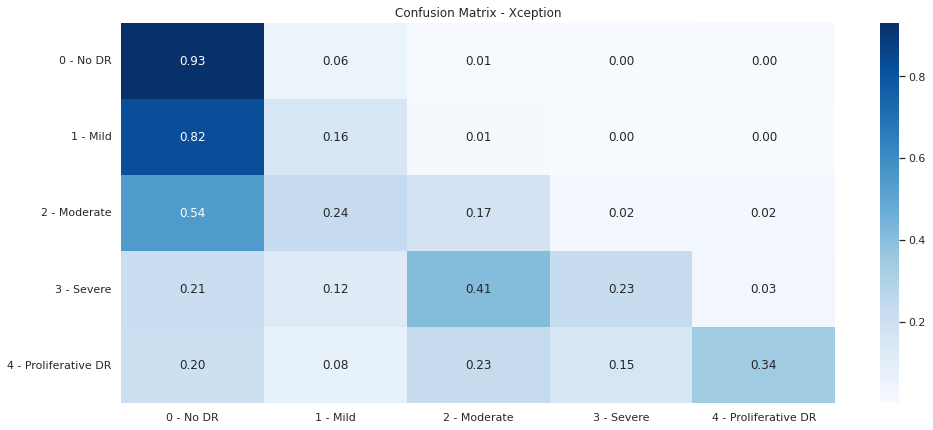

------------------InceptionResNetV2---------------------

FOLD 0:  0.7568314975392547
FOLD 1:  0.7981954534801968
FOLD 2:  0.7782751347550972
FOLD 3:  0.7542067026013592
FOLD 4:  0.8204827747832201
ENSEMBLE:  0.7619873447386923





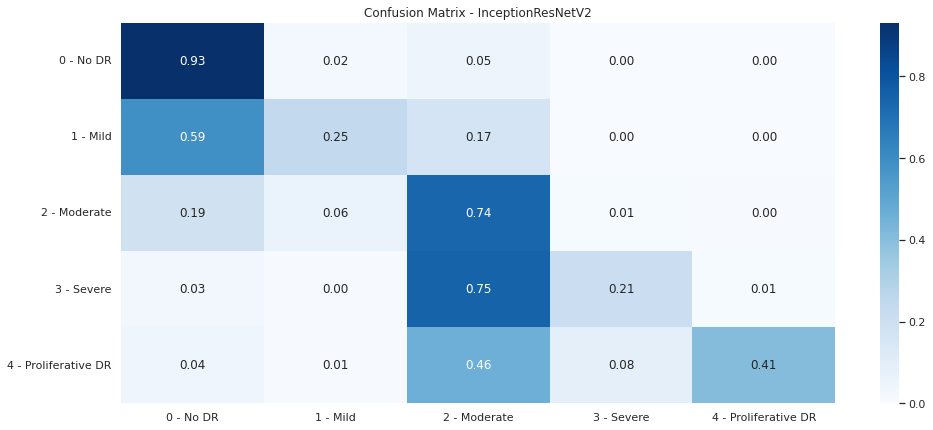

------------------NasNetMobile---------------------

FOLD 0:  0.7568314975392547
FOLD 1:  0.8186313569252402
FOLD 2:  0.5902038903210687
FOLD 3:  0.7478556362784158
FOLD 4:  0.8225451136629951
ENSEMBLE:  0.7608624326224513





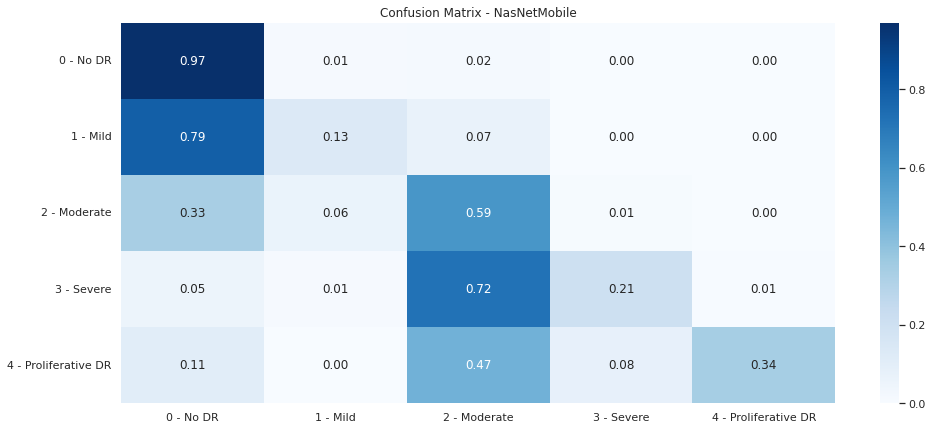

------------------EfficientNetB0---------------------

FOLD 0:  0.7568314975392547
FOLD 1:  0.7359503163815327
FOLD 2:  0.7359503163815327
FOLD 3:  0.7359503163815327
FOLD 4:  0.7359503163815327
ENSEMBLE:  0.7359503163815327





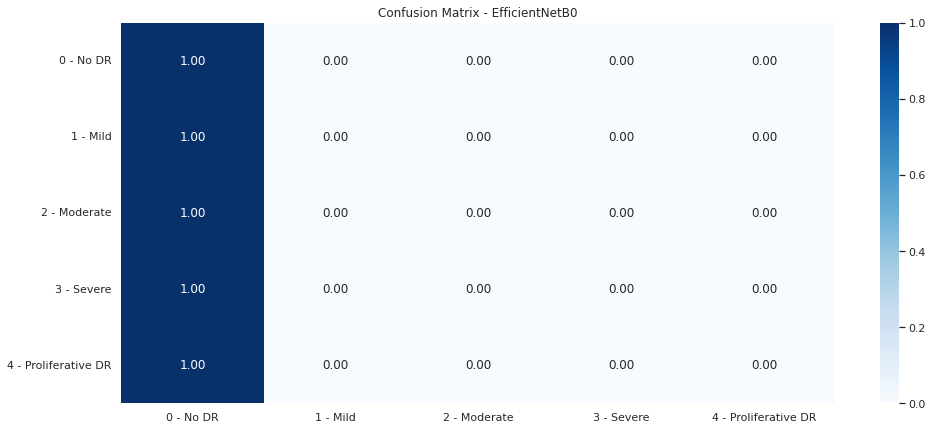

In [10]:
xception = [xception0,xception1,xception2,xception3,xception4]
xception = test_models('Xception',xception)

inception = [inception0,inception1,inception2,inception3,inception4]
inception = test_models('InceptionResNetV2', inception)

nasnet = [nasnet0,nasnet1,nasnet2,nasnet3,nasnet4]
nasnet = test_models('NasNetMobile', nasnet)

eff = [eff0,eff1,eff2,eff3,eff4]
eff = test_models('EfficientNetB0', eff)